# Deep Learning Coursework 2022 - Classifying Plankton

Student Number: 2407682H

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from   torch.utils.data import Dataset, DataLoader, Subset
from   torch.utils.data import random_split, WeightedRandomSampler
from   torchvision import transforms, utils
import torch.optim as optim

from sklearn.model_selection import train_test_split

import collections
from skimage import io, transform


device       = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )

# Data 
The following cells download the plankton dataset, turn it into a dictionary by loading it with PyTorch, and set some necessary flags so that the notebook may be run efficiently.

In [ ]:
# Load the data
url = "https://www.dropbox.com/s/v2udcnt98miwwrq/plankton.pt?dl=1"
!wget --no-check-certificate {url} -O plankton.pt

--2022-03-25 01:13:20--  https://www.dropbox.com/s/v2udcnt98miwwrq/plankton.pt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/v2udcnt98miwwrq/plankton.pt [following]
--2022-03-25 01:13:20--  https://www.dropbox.com/s/dl/v2udcnt98miwwrq/plankton.pt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8a8b27d26fbb54c98d1db8bc6f.dl.dropboxusercontent.com/cd/0/get/BiH0oJxLcKePw8z3O2LLz5uM0ODdXEOZKHajPYaebN-2jmv0EiPHoJM-rQjUYoCyVChbJFUUpK4QjodWiMaCXxHYIBgzJwRISKgx1W2nkWE4PuHcnfdUy_s6xwzHLran9nXRohLstpOI0GttrJJBHEqAp7QYP8YNGZOlEkGrXCGc5g/file?dl=1# [following]
--2022-03-25 01:13:20--  https://uc8a8b27d26fbb54c98d1db8bc6f.dl.dropboxusercontent.com/cd/0/get/BiH0oJxLcKePw8z3O2LLz5uM0ODdXEOZKHajPYaebN-2jmv0EiPHoJM-rQjUYoCyVChbJ

In [ ]:
data = torch.load('plankton.pt')    # Store data as dictionary from file

"""
 - The following two flags indicate whether or not certain parts of data
 - augmentation have been carried out. If they have then the process will
 - not be repeated for multiple runs of the notebook.
"""
rotated = False #Avoids re-rotating data

In [ ]:
"""
 - The next flags indicate whether or not to perform some action, e.g.
 - whether or not to train the model or load a pre-trained model from github
"""
trainModel = False  # Set to True if training, False if loading pre-trained model
hypTune    = False  # Set to True if hyperparameter tuning should be performed

# Clone Models from Github

In [ ]:
!git clone https://github.com/Horse-Lips/AICW

Cloning into 'AICW'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 5 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


# Viewing the Data
The below cell shows a selection of images from each class in the dataset and some observations are made.

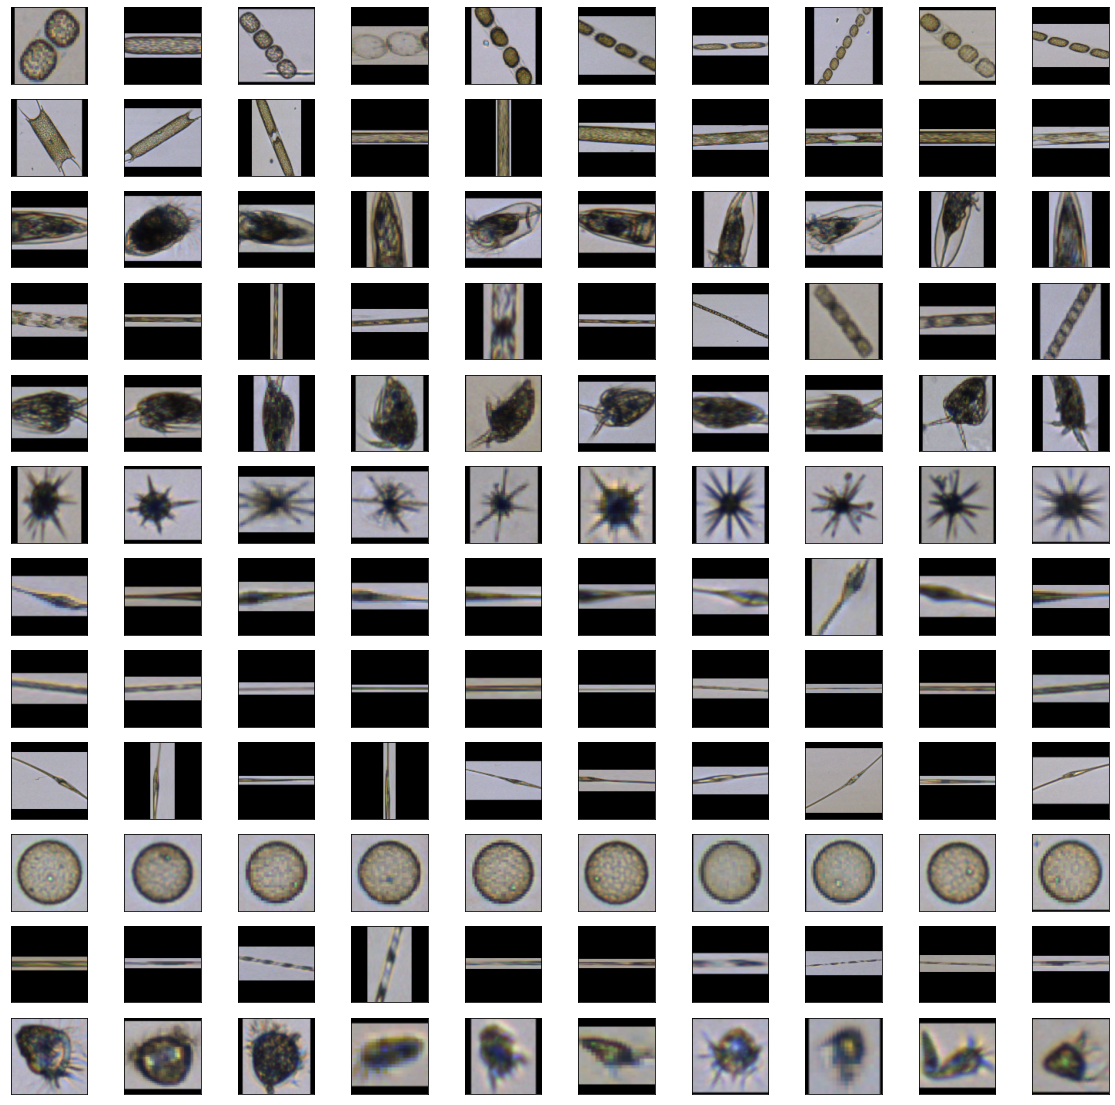

In [ ]:
classes    = data['labels'].unique()   # Classes
numClasses = len(classes)              # Number of classes

fig = plt.figure(figsize = (20, 20))

numExamples = 10 # Num examples to show of each class

for i in range(numClasses): 
  indexes = data['labels'] == classes[i]
  images  = data['images'][indexes, ...]

  for j in range(numExamples):
    ax = plt.subplot(numClasses, numExamples, i * numExamples + j + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(images[j, ...].permute(1, 2, 0))

plt.show()

There are a number of classes that appear decidedly unique in this dataset, for example class 9 shows a circular plankton that does not appear similar to any others in the data set. Some classes seem similar to one another, for examples classes 2 and 4, class 0 seems similar to some of class 3 (shown on the far right of the image), class 1 also seems similar to class 3 as well as classes 6, 7, 8, and 10. I believe that a basic model may have trouble distinguishing between these classes in some contexts.

# Data Augmentation

In [ ]:
print("The dataset contains ", len(data["images"]), " images.")
print("The amount in each class are the following:")
print(pd.Series(data['labels']).value_counts())

The dataset contains  1617  images.
The amount in each class are the following:
2.0     257
8.0     235
7.0     219
10.0    157
11.0    135
0.0     134
3.0     110
6.0      92
9.0      76
4.0      70
5.0      67
1.0      65
dtype: int64


The above shows that the dataset contains 1617 images which all belong to one of 12 categories. There is some data imbalance here, and it can be seen that in the largest class there are 257 images and in the smallest there are 65. It would be desirable to expand the data set due to its small size. The size of the dataset can be quadrupled by including all rotations of images by 90, 180, and 270 degrees and this operation is performed below.

In [ ]:
if not rotated: #Check that rotation has not already been applied
    # Concatenate all rotations including rotation 0 (original data)
    data["images"] = torch.cat([
        transforms.functional.rotate(data["images"],
        i * 90
        ) for i in range(0, 4)
    ])

    # Concatenate original labels 4 times, rotations are same class as original
    data["labels"] = torch.cat([data["labels"]] * 4)

    rotated = True

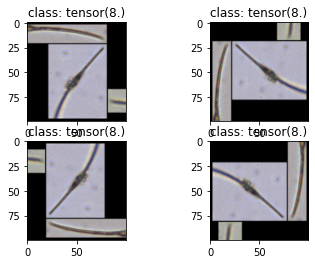

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

axes = [ax1, ax2, ax3, ax4]
randExample = np.random.randint(1617)   # Get a random image from original data

for i in range(len(axes)):
    axes[i].imshow(data["images"][randExample + (1617 * i)].permute(1, 2, 0))
    axes[i].set_title("class: " + str(data["labels"][randExample + (1617 * i)]))

plt.show()

In [ ]:
print("The dataset contains ", len(data["images"]), " images.")
print("The amount in each class are the following:")
print(pd.Series(data['labels']).value_counts())

The dataset contains  6468  images.
The amount in each class are the following:
2.0     1028
8.0      940
7.0      876
10.0     628
11.0     540
0.0      536
3.0      440
6.0      368
9.0      304
4.0      280
5.0      268
1.0      260
dtype: int64


The above shows that the dataset has been quadrupled by adding the earlier mentioned rotations of each of the images to the original dataset. A plot shows that all rotations fall within the same class, this cell may be rerun as it will generate a random example image each time in order to show that all rotations fall within the same class.

# Define a Custom Dataset Object
Here we define a custom dataset object [2] that will be used to maintain the data in the plankton.pt file. The dataset is indexable in order to retrieve an image and its label. The object is created by passing it the data dictionary defined above using the torch.load() function. An optional transformer object may be passed to the dataset object which will cause the dataset to apply an augmentation to the image before it is returned when the dataset object is indexed.

In [ ]:
class customDataSet(Dataset):
    """
     - Here we define a custom dataset object for use with the custom dataloader
     - The dataset is indexable and will provide data augmentation through
     - a transformer object called "transform"
    """
    def __init__(self, dataDict, transform = None):
        """
         - Inputs:
            - dataDict:  A dictionary containing images, labels, and names
                         as in the data dictionary loaded from plankton.pt
            - transform: The transformer object used to apply data augmentation
                         to the dataset
        """
        self.images    = dataDict["images"]            # Place images in df
        self.labels    = pd.Series(dataDict["labels"]) # Place labels in df
        self.transform = transform                     # Transform if given


    def __len__(self):
        return len(self.images)


    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()  #Convert tensor of indexes to list

        if self.transform is not None:  # Apply transform if one is defined
            return (self.transform(self.images[index]), self.labels[index])

        return (self.images[index], self.labels[index])

# Create Train and Test Sets
Here the plankton data is placed into a custom dataset with no transform, then the data is split into train and test with a 75-25 split respectively. The split is created using sklearn's train_test_split function [4], as we are able to use the stratify flag in order to evenly split the data in each class between train and tests with the percentages required. This is a necessary step as if we were to split the data randomly, for example using PyTorch's random split utility, there may be a lack of some class in the training set or test set.

In [ ]:
planktonDataset = customDataSet(data)   # Make dataset object with plankton data

trainIndices, testIndices = train_test_split(   # Get train and test splits
    np.arange(len(data["labels"])),             # Indexes of labels
    stratify = data["labels"]                   # Evenly distribute classes
)

trainSet = Subset(planktonDataset, trainIndices)
testSet  = Subset(planktonDataset, testIndices)

print("Train set size: ", len(trainSet))
print("Test set size: ",  len(testSet))

Train set size:  4851
Test set size:  1617


# Define a Data Loader
Here dataloader objects are created for the train and test sets using PyTorch's DataLoader object [2]. Using a dataloader allows the batching and shuffling of data stored in the underlying dataset which will allow more efficient training. This also provides a level of ease when passing data to the neural network during training. Here the training set's data loader is created with a batch size of 24, the test set's data loader is not shuffled and does not have a batch size.

An additional step could be made to mitigate the effects of the data imbalance through using PyTorch's WeightedRandomSampler [5] as the sampler object in the DataLoader. This would allow batches to be sampled with replacement before being passed to the neural network. This step has not been used as I believe the earlier sklearn train test split process also mitigates the effects of data imbalance.

In [ ]:
trainLoader = DataLoader(
    trainSet,
    batch_size = 24
)

testLoader = DataLoader(
    testSet
)

# Create the Network

The fiveConv function below will create and return a model with five convolutional layers with a 3x3 kernel and a stride of one. After convolutions, the input image will be passed to the dense layers of the neural network. Five convolutional layers were chosen as the network will effectively process each image before passing it to the dense layers. Previous attempts were made with either more or less convolutional layers, and more did not seem to effect the performance in this context. The kernel sizee of 3x3 was also chosen through previous experimentation. Kernel sizes of 3x3, 5x5, and 7x7 were experimented with and 3x3 seems to be the most effective for this task. The transformations carried out in the dense network after convolution was also tuned during this testing stage, and therefore these values have been tuned accordingly during earlier experimentation. 

In [ ]:
def fiveConv():
    return nn.Sequential(
        nn.Conv2d(3, 10, 3),    # 3 in channels, 10 out, 3x3 square kernel
        nn.ReLU(),              # Shape = (100 - (3 - 1)) = 98
        nn.MaxPool2d(2),        # Max pooling over a 2x2 window, Shape = 98 / 2 = 

        nn.Conv2d(10, 25, 3),   # 10 in channels, 25 out, 3x3 square kernel
        nn.ReLU(),              # Shape = (49 - (3 - 1)) = 47
        nn.MaxPool2d(2),        # Shape = 47 / 2 = 23

        nn.Conv2d(25, 64, 3),   # 25 in channels, 64 out, 3x3 square kernel
        nn.ReLU(),              # Shape = (23 - (3 - 1)) = 21
        nn.MaxPool2d(2),        # Shape = 21 / 2 = 10

        nn.Conv2d(64, 128, 3),  # 64 in channels, 128 out, 3x3 square kernel
        nn.ReLU(),              # Shape = (10 - (3 - 1)) = 8
        nn.MaxPool2d(2),        # Shape = 8 / 2 = 4

        nn.Conv2d(128, 256, 3), # 128 in channels, 256 out, 3x3 square kernel
        nn.ReLU(),              # Shape = (4 - (3 - 1)) = 2
        nn.MaxPool2d(2),        # Shape = 2 / 2 = 1

        nn.Flatten(),           # Shape = [n, (256 * 1 * 1)] = [n, 256]
        
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 1024),
        nn.ReLU(),
        nn.Linear(1024, 1250),
        nn.ReLU(),
        nn.Linear(1250, 1000),
        nn.ReLU(),
        nn.Linear(1000, 750),
        nn.ReLU(),
        nn.Linear(750, 500),
        nn.ReLU(),
        nn.Linear(500, 250),
        nn.ReLU(),
        nn.Linear(250, 125),
        nn.ReLU(),
        nn.Linear(125, 100),
        nn.ReLU(),
        nn.Linear(100, 75),
        nn.ReLU(),
        nn.Linear(75, 50),
        nn.ReLU(),
        nn.Linear(50, 16),
        nn.ReLU(),
        nn.Linear(16, 12),
    )

#Training Loop
A relatively generic training loop is defined below, and detailed comments serve to explain its functioning. The loop will run for the given number of epochs, or episodes, and is given a model object to train. An optimiser object is also expected, for example Adam which is used later. The function also expects a loss function and a data loader as defined previously. Some extra optional parameters are also available, showGraph will show a plot of training loss over epochs, showEpoch will cause the loop to print training loss every 5 epochs. The transform parameter is an optional parameter for a PyTorch transform object, this is used to perform on-demand, or on-line, data augmentation and this is explained in a later section of the report (See On-Demand Data Augmentation).

In [ ]:
def trainLoop(nEpochs, model, opt, device, lossFunc, loader, 
                        showGraph = False, showEpoch = False, transform = None):
    """
     - Function that handles the training loop for a NN.
     - Inputs:
     -   nEpochs:  Number of epochs or training episodes
     -   model:    NN model to train
     -   opt:      Optimiser to use
     -   device:   Device to use, e.g. CPU or CUDA
     -   lossFunc: Loss function to use
     -   loader:   PyTorch Data Loader object for training data
     -
     -   showGraph: Whether or not to show epoch/loss graph after training
     -   showEpoch: Whether or not to show epoch info every 5 epochs
     -   transform: A custom PyTorch transform object for augmenting data
     -              during training
     -
     - Standard training loop for a PyTorch NN. Will run for nEpoch epochs or
     - episodes and show a graph of epoch/training loss. A pytorch transformer
     - can be given to perform on-demand data augmentation with a 30% chance per
     - batch. This decision was made so that the NN may view the orginal
     - training data without alteration.
    """
    epochPrint = 5
    model = model.to(device)

    trainLosses = []    # Used for graphing training results

    for epoch in range(1, nEpochs + 1):
        trainLoss = 0.0

        for imageBatch, labelBatch in loader:
            if transform is not None and np.random.uniform() > 0.75:
                imageBatch = transform(imageBatch)  # Apply transform if given

            # Forward pass
            outputs = model( # Make predictions for batch
                imageBatch.to(device).float()
            )

            # Backward pass
            loss = lossFunc(
                outputs,    # Calculate loss based on predictions and labels
                labelBatch.type(torch.LongTensor).to(device)
            )

            opt.zero_grad() # Zero the gradient

            loss.backward() # Compute the backward pass
            
            opt.step()      # Make a step with the optimiser
            
            trainLoss += loss.item()    # Cumulative loss over epoch

        trainLosses.append(trainLoss)

        if showEpoch and epoch % epochPrint == 0:
            print('Epoch {}, Training loss {}'.format(epoch, float(trainLoss)))

    
    if showGraph:   # Show a graph of training results if option is selected
        plt.plot(range(nEpochs), trainLosses)
        plt.xlabel("Epoch")
        plt.ylabel("Training Loss")

        plt.show()

# Test Loop
A test loop is also defined, given a model, device, and data loader for test data the loop will use the model to predict the labels of the test data and report average loss and accuracy.

In [ ]:
def testLoop(model, device, loader):
    model.eval()            # Set model to evaluation mode
    model = model.to(device)

    testLoss = 0
    correct  = 0

    classAccuracy = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    classTotal    = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

    with torch.no_grad():   # Do not compute gradients
        for image, label in loader:     # Get each image and label from test set
            image = image.to(device)
            label = label.type(torch.LongTensor).to(device)

            output = model(image)       # Make Prediction for image

            testLoss += F.nll_loss( # Sum of batch loss
                output,
                label,
                reduction = 'sum'
            ).item()

            pred = output.argmax(   # Index of max log-prob
                dim = 1,
                keepdim = True
            )

            correct += pred.eq(label.view_as(pred)).sum().item()
            classAccuracy[int(label)] += pred.eq(label.view_as(pred)).sum().item()
            classTotal[int(label)] += 1


    testLoss /= len(loader)

    print(
        "=== Test set ===\n",
        "Average Loss: ", testLoss, "\n",
        "Accuracy: ",     correct,  "/",  len(loader), "\n",
        "(", 100.0 * correct / len(loader), "%)\n"
    )

    print("Class Accuracy:")
    for i in range(len(classAccuracy)):
        print("Class: ", i, " ", classAccuracy[i], "/", classTotal[i], 
                            "(", (classAccuracy[i] / classTotal[i]) * 100, "%)")

    return testLoss, correct / len(loader) * 100.0

# Defining Parameters and Training the Model
Here a number of arguments and parameters are defined for the model to be trained. The number of epochs is set to 250 and a new model object is created as the earlier defined fiveConv convolutional network. The optimiser chosen is Adam. There was no particular motivation behind choosing Adam other than that it outperformed SGD during experimentation, this could have been due to sparse gradients as this is where Adam excels, however no investigation took place in order to determine why this was. Cross entropy loss was chosen as the loss function, this loss function is used in classification problems where model outputs are probabilities (i.e. between 0 and 1), and therefore it was chosen as a relatively standard loss function for such a task.

In [ ]:
if trainModel:
    numEpochs    = 250
    basicModel   = fiveConv()

    opt          = optim.Adam(basicModel.parameters(), lr = 0.001)

    lossFunc     = nn.CrossEntropyLoss()


    trainLoop(
        numEpochs,          # Number of epochs, or episodes
        basicModel,         # The NN model to be trained
        opt,                # The optimiser object to use
        device,             # The device to use, e.g. CPU or CUDA
        lossFunc,           # The loss function to be used
        trainLoader,        # The data loader for training data
        showGraph = True,   # Whether or not to show a loss/epoch graph
        showEpoch = True,   # Whether or not to show epoch loss
        transform = None    # Transform used to transform data
    )

else:
    basicModel = torch.load("AICW/fiveConv250.model")

In [ ]:
avgLoss, acc = testLoop(
    basicModel,      # Trained model to predict test set with
    device,     # Device to use, e.g. CPU or CUDA
    testLoader  # Data loader for test data
)

=== Test set ===
 Average Loss:  -122.56199544074731 
 Accuracy:  1273 / 1617 
 ( 78.726035868893 %)

Class Accuracy:
Class:  0   123 / 134 ( 91.7910447761194 %)
Class:  1   58 / 65 ( 89.23076923076924 %)
Class:  2   248 / 257 ( 96.49805447470817 %)
Class:  3   3 / 110 ( 2.727272727272727 %)
Class:  4   62 / 70 ( 88.57142857142857 %)
Class:  5   65 / 67 ( 97.01492537313433 %)
Class:  6   82 / 92 ( 89.13043478260869 %)
Class:  7   149 / 219 ( 68.0365296803653 %)
Class:  8   216 / 235 ( 91.91489361702128 %)
Class:  9   76 / 76 ( 100.0 %)
Class:  10   58 / 157 ( 36.94267515923567 %)
Class:  11   133 / 135 ( 98.51851851851852 %)


Here we see the training loss every 5 epochs over the 250 total epochs, and a graph shows the training loss per epoch. We can see that the model performs averagely with decent accuracy on the test set, however it is possible to improve this performance gradually. Attempts are made at improving the accuracy of the model throughout the remainder of the notebook.

The output of the test loop not only shows overall model accuracy, but accuracy per class in the dataset. We can see that, while the model is able to predict many classes quite well it has terrible performance on class 3 and quite poor performance on class 10. Below we select some random images from each class for observation:

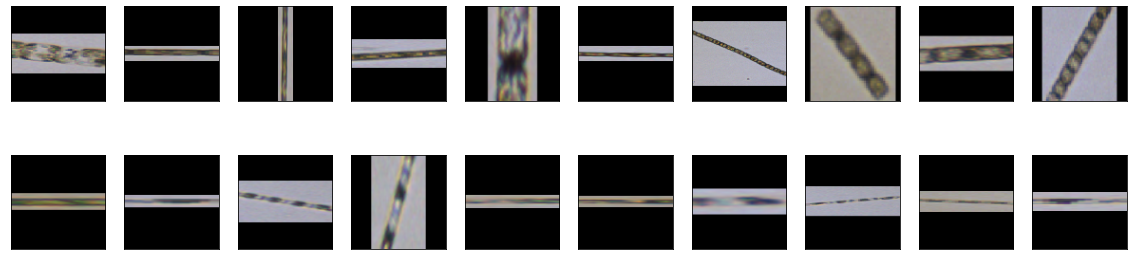

In [ ]:
classes    = [3, 10]   # Classes
numClasses = len(classes)              # Number of classes

fig = plt.figure(figsize = (20, 5))

numExamples = 10 # Num examples to show of each class

for i in range(numClasses): 
  indexes = data['labels'] == classes[i]
  images  = data['images'][indexes, ...]

  for j in range(numExamples):
    ax = plt.subplot(numClasses, numExamples, i * numExamples + j + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(images[j, ...].permute(1, 2, 0))

plt.show()

It seems that these classes of plankton appear to be quite similar and, as discussed at the start of this report, are similar to classes 1, 6, 7, and 8 also. I believe that this lack of accuracy is likely due to mis-classifying classes 3 and 10 as these instead as the accuracy seems to remain high for these classes. Data augmentation and the ability to expose the model to more images from an expanded dataset may aid in mitigating this problem.

# On-Demand Data Augmentation
At the start of the notebook, the data was rotated in order to increase the size of the dataset. This is know as data augmentation and may improve the performance of a model as the network is exposed to a larger amount of different images. While this may aid in training the model, there is still a risk of overfitting as the model will be exposed to the same set of images throughout training. We are able to prevent this using on-demand data augmentation, a process through which images are augmented before the network is exposed to them meaning that is is near-impossible for the model to ever see an image more than once. Due to this fact, this process technically also increases the size of the dataset. The definition of the training loop function allows for a Pytorch transformer [1] to be passed which will be applied to image batches each time one is retrieved from the data loader. Below a custom transformer is defined which will be given to the training loop function, and therefore data will be randomly augmented on-demand during training.

The transformer will select from the following transforms:
* Randomly rotating the image between -30 and 30 degrees
    * The data has already been rotated prior to training the earlier model, and observing the data shows that several images of plankton are at slight rotations. Rotating each image randomly may aid in allowing the model to distinguish the difference between plankton in different classes or to acknowledge plankton in the same class more effectively. 30 degrees was chosen as the rotation is not too extreme and earlier rotations have already been applied.
* Applying a random perspective distortion
    * The images in the dataset mostly appear to be well-centred, however some are at slight angles or rotations within the image. Applying a random perspective distortion may aid training.
* Applying a random sharpness adjustment
    * Adjusting the sharpness of an image at random may aid training, as some plankton within similar classes appear to have slightly different colours perhaps due to their surroundings.
* Randomly cropping the image and resizing to its original size
    * Randomly cropping images could aid in the same way that a random perspective distortion does in that some images feature plankton at different distances from the camera. As a result, this may aid in helping the model recognise plankton in the same class.
* Applying a random colour jitter which will alter the brightness, contrast, saturation, and hue of the image
    * This augmentation has a similar motivation to the sharpness augmentation, however this will alter several more attributes of the colour of the image. This augmentation may improve training, however with the potential to completely alter the image it may prove that it worsens training.

As the process of data augmentation drastically increases the size of the data set, the model is trained for a lot more epochs to ensure that the model has sufficient exposure to as many different types of image. I believe that this does not compromise comparisons between the previous model, as exposing the model with no data augmentation would only contribute to overfitting and therefore the number of epochs for the previous model should not be increased.

In [ ]:
customTransform = transforms.RandomChoice([
    transforms.RandomRotation(30),          # Random 360 degree rotation
    transforms.RandomPerspective(),          # Random perspective distortion
    transforms.RandomAdjustSharpness(1.4),   # Randomly alter sharpness
    transforms.RandomResizedCrop((100, 100)),# Randomly crop, resize to 100x100
    transforms.ColorJitter()                 # Randomly apply colour jitter
])

In [ ]:
if trainModel:
    numEpochs = 1000
    augModel = fiveConv()

    opt          = optim.Adam(augModel.parameters(), lr = 0.001)

    device       = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )

    lossFunc     = nn.CrossEntropyLoss()

    trainLoop(
        numEpochs,          # Number of epochs, or episodes
        augModel,           # The NN model to be trained
        opt,                # The optimiser object to use
        device,             # The device to use, e.g. CPU or CUDA
        lossFunc,           # The loss function to be used
        trainLoader,        # The data loader for training data
        showGraph = True,   # Whether or not to show a loss/epoch graph
        showEpoch = True,   # Whether or not to show epoch loss
        transform = customTransform    # Transform used to transform data
    )

else:
    augModel = torch.load("AICW/fiveConv1000Aug.model")

In [ ]:
testLoop(
    augModel,      # Trained model to predict test set with
    device,     # Device to use, e.g. CPU or CUDA
    testLoader  # Data loader for test data
)

=== Test set ===
 Average Loss:  6.661738650162572 
 Accuracy:  1465 / 1617 
 ( 90.59987631416203 %)

Class Accuracy:
Class:  0   128 / 134 ( 95.52238805970148 %)
Class:  1   38 / 65 ( 58.46153846153847 %)
Class:  2   249 / 257 ( 96.88715953307393 %)
Class:  3   91 / 110 ( 82.72727272727273 %)
Class:  4   69 / 70 ( 98.57142857142858 %)
Class:  5   67 / 67 ( 100.0 %)
Class:  6   88 / 92 ( 95.65217391304348 %)
Class:  7   197 / 219 ( 89.95433789954338 %)
Class:  8   218 / 235 ( 92.76595744680851 %)
Class:  9   76 / 76 ( 100.0 %)
Class:  10   109 / 157 ( 69.42675159235668 %)
Class:  11   135 / 135 ( 100.0 %)


(6.661738650162572, 90.59987631416203)

This model shows a modest performance increase, with the model now showing an accuracy of close to 90% on the test set. This shows that data augmentation allows the model to more accurately identify unseen images due to the amount and variation of images seen during training. The lower performance of the initial model could also be down to overfitting, as no data augmentation was applied. It can also be seen that data augmentation has greatly increased the accuracy for classes 3 and 10 which were problematic in the initial model. Class 3 has increased from increadly low accuracy to over 80% which implies that data augmentation has impacted the model very positively. Class 10 has also increased moderately which is also a positive increase. It appears that there is still room to improve the model without simply augmenting the data or training for longer, and another approach is employed in the following.

# Hyper Parameter Tuning

The previous experiments have carried out model training using an optimiser with a predefined learning rate and batch size for the data loader. These are usually defined as default parameters or simply a widely used values, however it is possible to tune this hyperparameter in order to determine the most effective learning rate for the model for example. 

In order to tune the hyperparameters of the model Ax [6], an experimental library for hyperparameter tuning is used.

In [ ]:
!pip install ax-platform

from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate, CNN

     |████████████████████████████████| 950 kB 8.2 MB/s 
     |████████████████████████████████| 347 kB 59.4 MB/s 
     |████████████████████████████████| 310 kB 57.5 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=fdada4e1b6f5e3f5e02020171892ba519a49bc6c678f09625931f1b5af7c0d47
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


Defined below is the evaluation function for use with the Ax hyper parameter tuning library. In the function, a model is trained over a small number of epochs in order to determine the optimal learning rate and batch size, this is then evaluated with the Ax evaluate function, which in turn will allow us to determine the best learning rate and batch size. Ideally the evaluate function should use a validation set, however due to the small size of the data set the test set has been used.

In [ ]:
def tuneParams(params):
    numEpochs = 10

    model = fiveConv()

    opt = optim.Adam(model.parameters(), lr = params["lr"])

    lossFunc = nn.CrossEntropyLoss()

    trainLoader = DataLoader(
        trainSet,
        batch_size = params["batchSize"]
    )

    trainLoop(
        numEpochs,           # Number of epochs, or episodes
        model,               # The NN model to be trained
        opt,                 # The optimiser object to use
        device,              # The device to use, e.g. CPU or CUDA
        lossFunc,            # The loss function to be used
        trainLoader,         # The data loader for training data
        showGraph = False,   # Whether or not to show a loss/epoch graph
        showEpoch = False,   # Whether or not to show epoch loss
        transform = None     # Transform used to transform data
    )

    return evaluate(
        net = model,
        data_loader = testLoader,
        dtype = torch.float,
        device = device,
    )

Here the best parameters are determined using Ax's optimize function. A dictionary of parameters is used with pre-defined ranges of values. In this case only the learning rate and batch size are optimised.

In [ ]:
if hypTune:
    best_parameters, values, experiment, model = optimize(
        parameters = [
            {
                "name": "lr",
                "type": "range",
                "value_type": "float",
                "bounds": [1e-6, 0.4],
                "log_scale": True
            },
            {
                "name": "batchSize",
                "type": "range",
                "value_type": "int",
                "bounds": [8, 64]
            },
        ],

        evaluation_function = tuneParams,
        objective_name      = 'accuracy',
    )

    print(best_parameters)

Putting this hyperparameter tuning together with on-line data augmentation we are able to train the model once more in order to monitor how performance has been affected.

In [ ]:
if trainModel:
    # NOTE: The learning rate and batch size have been hard-
    # coded as the tuning process is quite time consuming
    learningRate = 0.00023808439071852514
    batchSize    = 8

    trainLoader = DataLoader(
        trainSet,
        batch_size = batchSize
    )
    
    numEpochs = 1000
    hypModel = fiveConv()

    opt          = optim.Adam(hypModel.parameters(), lr = learningRate)

    device       = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )

    lossFunc     = nn.CrossEntropyLoss()

    trainLoop(
        numEpochs,          # Number of epochs, or episodes
        hypModel,              # The NN model to be trained
        opt,                # The optimiser object to use
        device,             # The device to use, e.g. CPU or CUDA
        lossFunc,           # The loss function to be used
        trainLoader,        # The data loader for training data
        showGraph = True,   # Whether or not to show a loss/epoch graph
        showEpoch = True,   # Whether or not to show epoch loss
        transform = customTransform    # Transform used to transform data
    )

else:
    hypModel = torch.load("AICW/fiveConv1000Hyp.model")

In [ ]:
testLoop(
    hypModel,   # Trained model to predict test set with
    device,     # Device to use, e.g. CPU or CUDA
    testLoader  # Data loader for test data
)

=== Test set ===
 Average Loss:  134.81592808819585 
 Accuracy:  1545 / 1617 
 ( 95.54730983302412 %)

Class Accuracy:
Class:  0   133 / 134 ( 99.25373134328358 %)
Class:  1   57 / 65 ( 87.6923076923077 %)
Class:  2   256 / 257 ( 99.61089494163424 %)
Class:  3   104 / 110 ( 94.54545454545455 %)
Class:  4   68 / 70 ( 97.14285714285714 %)
Class:  5   67 / 67 ( 100.0 %)
Class:  6   90 / 92 ( 97.82608695652173 %)
Class:  7   209 / 219 ( 95.4337899543379 %)
Class:  8   221 / 235 ( 94.04255319148936 %)
Class:  9   76 / 76 ( 100.0 %)
Class:  10   129 / 157 ( 82.16560509554141 %)
Class:  11   135 / 135 ( 100.0 %)


(134.81592808819585, 95.54730983302412)

Here we see that even slightly tuning the hyper-parameters of the model has increased the performance of the model with accuracy falling above 90 percent on the test data set. Most individual classes have an accuracy of above or close to 90% and this implies that tuning the hyperparameters of the model has had a greatly positive effect on the model. Classes 3 and 10, which were causing earlier issues with accuracy, now have very good classification accuracy and the remaining classes have all had slight increases and some slightly larger increases, for example class 1 has increased from from moderate accuracy to relatively high accuracy simply through tuning hyperparameters.

# Limitations
Some limitations were identified during the course of this project, mainly due to time limitations. The first of these limitations is the train and test splitting, this was determined in a fashion that attempted to eliminate the data imbalance, however cross-validation could prove more useful and aid in tuning the model more effectively. Another limitation is with the model itself. The model was defined with prior experience in mind and therefore it was not compared to a pre-existing model architecture in order to assess comparitive performance increases. Another limitation related to time constraints is the choice of data augmentation, perhaps with more different types of data augmentation and more time to train the models, better performance could be achieved. Another potential improvement to the model could be the use of an auto-encoder. An auto-encoder could have been used for unsupervised pre-training in order to learn an optimal representation of the data and ignore redundant data or data that is not considered "useful" to training. One final limitation is the memory limitations encountered during hyperparameter tuning. It was attempted to parameterise layer sizes within the network in order to determine optimal sizes during hyperparameter tuning, however this came at a large memory cost and therefore was not possible on either Colab or the personal machine that experiments were being conducted on.

# References
[1] https://pytorch.org/vision/stable/transforms.html  
[2] https://pytorch.org/tutorials/beginner/data_loading_tutorial.html  
[3] https://machinelearningmastery.com/difference-test-validation-datasets/  
[4] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
[5] https://pytorch.org/docs/master/data.html#torch.utils.data.sampler.WeightedRandomSampler  
[6] https://ax.dev/ 
